In [2]:
import essentia.standard as ess
import librosa as lib
import numpy as np
import matplotlib.pyplot as plt
# import HTKPython as HTK
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from essentia import Pool
from scipy import pi
import   scipy.io as sp
from struct import unpack, pack
import numpy

LPC = 1
LPCREFC = 2
LPCEPSTRA = 3
LPCDELCEP = 4
IREFC = 5
MFCC = 6
FBANK = 7
MELSPEC = 8
USER = 9
DISCRETE = 10
PLP = 11

_E = 0000100 # has energy
_N = 0000200 # absolute energy supressed
_D = 0000400 # has delta coefficients
_A = 0001000 # has acceleration (delta-delta) coefficients
_C = 0002000 # is compressed
_Z = 0004000 # has zero mean static coefficients
_K = 0010000 # has CRC checksum
_O = 0020000 # has 0th cepstral coefficient
_V = 0040000 # has VQ data
_T = 0100000 # has third differential coefficients

def htk_open(f, mode=None, veclen=13):
    """Open an HTK format feature file for reading or writing.
    The mode parameter is 'rb' (reading) or 'wb' (writing)."""
    if mode is None:
        if hasattr(f, 'mode'):
            mode = f.mode
        else:
            mode = 'rb'
    if mode in ('r', 'rb'):
        return HTKFeat_read(f) # veclen is ignored since it's in the file
    elif mode in ('w', 'wb'):
        return HTKFeat_write(f, veclen)
    else:
        raise Exception, "mode must be 'r', 'rb', 'w', or 'wb'"

class HTKFeat_read(object):
    "Read HTK format feature files"
    def __init__(self, filename=None):
        self.swap = (unpack('=i', pack('>i', 42))[0] != 42)
        if (filename != None):
            self.open(filename)

    def __iter__(self):
        self.fh.seek(12,0)
        return self

    def open(self, filename):
        self.filename = filename
        self.fh = file(filename, "rb")
        self.readheader()

    def readheader(self):
        self.fh.seek(0,0)
        spam = self.fh.read(12)
        self.nSamples, self.sampPeriod, self.sampSize, self.parmKind = \
                       unpack(">IIHH", spam)
        # Get coefficients for compressed data
        if self.parmKind & _C:
            self.dtype = 'h'
            self.veclen = self.sampSize / 2
            if self.parmKind & 0x3f == IREFC:
                self.A = 32767
                self.B = 0
            else:
                self.A = numpy.fromfile(self.fh, 'f', self.veclen)
                self.B = numpy.fromfile(self.fh, 'f', self.veclen)
                if self.swap:
                    self.A = self.A.byteswap()
                    self.B = self.B.byteswap()
        else:
            self.dtype = 'f'    
            self.veclen = self.sampSize / 4
        self.hdrlen = self.fh.tell()

    def seek(self, idx):
        self.fh.seek(self.hdrlen + idx * self.sampSize, 0)

    def next(self):
        vec = numpy.fromfile(self.fh, self.dtype, self.veclen)
        if len(vec) == 0:
            raise StopIteration
        if self.swap:
            vec = vec.byteswap()
        # Uncompress data to floats if required
        if self.parmKind & _C:
            vec = (vec.astype('f') + self.B) / self.A
        return vec

    def readvec(self):
        return self.next()

    def getall(self):
        self.seek(0)
        data = numpy.fromfile(self.fh, self.dtype)
        if self.parmKind & _K: # Remove and ignore checksum
            data = data[:-1]
        data = data.reshape(len(data)/self.veclen, self.veclen)
        if self.swap:
            data = data.byteswap()
        # Uncompress data to floats if required
        if self.parmKind & _C:
            data = (data.astype('f') + self.B) / self.A
        return data

class HTKFeat_write(object):
    "Write Sphinx-II format feature files"
    def __init__(self, filename=None,
                 veclen=13, sampPeriod=100000,
                 paramKind = (MFCC | _O)):
        self.veclen = veclen
        self.sampPeriod = sampPeriod
        self.sampSize = veclen * 4
        self.paramKind = paramKind
        self.dtype = 'f'
        self.filesize = 0
        self.swap = (unpack('=i', pack('>i', 42))[0] != 42)
        if (filename != None):
            self.open(filename)

    def __del__(self):
        self.close()

    def open(self, filename):
        self.filename = filename
        self.fh = file(filename, "wb")
        self.writeheader()

    def close(self):
        self.writeheader()

    def writeheader(self):
        self.fh.seek(0,0)
        self.fh.write(pack(">IIHH", self.filesize,
                           self.sampPeriod,
                           self.sampSize,
                           self.paramKind))

    def writevec(self, vec):
        if len(vec) != self.veclen:
            raise Exception("Vector length must be %d" % self.veclen)
        if self.swap:
            numpy.array(vec, self.dtype).byteswap().tofile(self.fh)
        else:
            numpy.array(vec, self.dtype).tofile(self.fh)
        self.filesize = self.filesize + self.veclen

    def writeall(self, arr):
        for row in arr:
            self.writevec(row)

 



In [3]:
########### extract filterbank with htk
URImfcFile = 'HTK/vignesh.mfc_no_preemph'

HTKFeat_reader =  htk_open(URImfcFile, 'rb')
htkMFCC = HTKFeat_reader.getall()
htkMFCC = htkMFCC.T
htkMFCC =htkMFCC[[-1,0,1,2,3,4,5,6,7,8,9,10,11],:]
fs = 44100
audio = ess.MonoLoader(filename = 'audio/vignesh.wav', 
                                      sampleRate = fs)()
# dynamic range expansion as done in Matlab HTK implementation
audio = audio*2**15
matlabMFCC= sp.loadmat('matlab/MFCCs.mat')['MFCCs']
#matlabMFCC = matlabMFCC[[-1,0,1,2,3,4,5,6,7,8,9,10,11],:]
print np.max(audio)
print np.min(audio)

IOError: [Errno 2] No such file or directory: 'matlab/MFCCs.mat'

Here the MFCC are computed with Essentia and compared with librosa, error is up to 1.6 probably because of small differences in the way of computing the filterbank. 

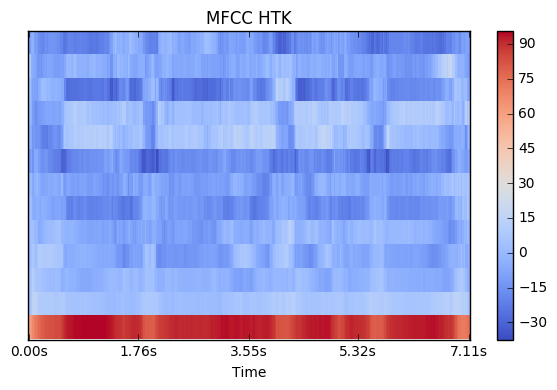

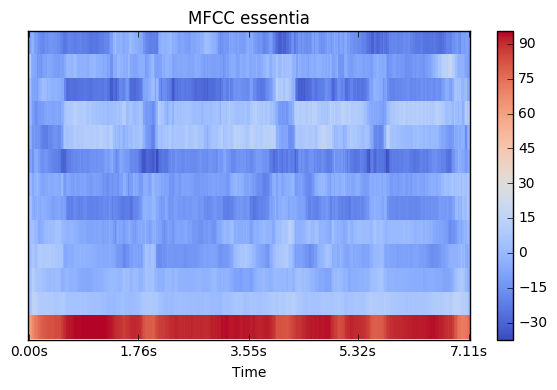

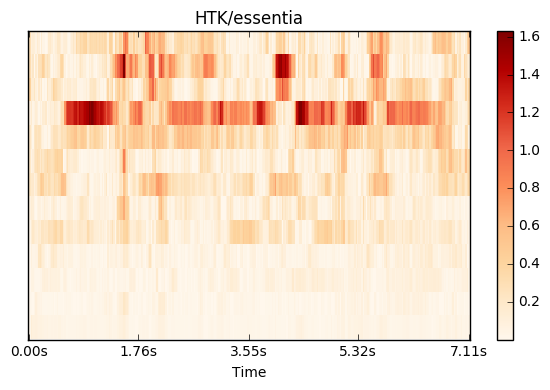

In [28]:
frameSize = 1102
hopSize = 441
fftSize = 2048
spectrumSize= fftSize//2+1
zeroPadding = fftSize - frameSize

w = ess.Windowing(type = 'hamming', 
                    size = frameSize, 
                    zeroPadding = zeroPadding,
                    normalized = False,
                    zeroPhase = False)

melsEssentia = ess.MelBands(inputSize = spectrumSize,
                    type = 'power', 
                    warpingFormula = 'htkMel',
                    weighting = 'linear',
                    highFrequencyBound = 8000,
                    lowFrequencyBound = 300,
                    numberBands = 26,
                    normalize = 'unit_max',)

mfccEssentia = ess.MFCC(inputSize = spectrumSize,
                    type = 'magnitude', 
                    warpingFormula = 'htkMel',
                    weighting = 'linear',
                    highFrequencyBound = 8000,
                    lowFrequencyBound = 0,
                    numberBands = 26,
                    numberCoefficients = 13,
                    normalize = 'unit_max',
                    dctType = 3,
                    logType = 'log',
                    liftering = 22)

mfccEssentiaOld = ess.MFCC(inputSize = spectrumSize,
                    highFrequencyBound = 8000,
                    numberBands = 26,
                    numberCoefficients = 13)


spectrum = ess.Spectrum(size = fftSize)
pool = Pool()

for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize , startFromZero = True, validFrameThresholdRatio = 1):
    spect = spectrum(w(frame))
    pool.add('MFCC',mfccEssentia(spect)[1])
    pool.add('MFCCOld',mfccEssentiaOld(spect)[1])
    pool.add('MelBands',melsEssentia(spect))
    
    
essentiaMFCC = np.array(pool['MFCC'].T);
essentiaMFCCOld = np.array(pool['MFCCOld'].T);
essentiaMelBands = np.array(pool['MelBands'].T);

# Processing imitating Matlab
coefficients = 13
bands = 26

# DCT bassis HTK formula, slighly different to librosa implementation
basis1 = np.ones((coefficients, bands))
librosaMFCC = np.zeros([13,307])
liftering = 22

for i in range(0, coefficients):
    for j in range (0, bands):
        basis1[i, j] = np.sqrt(2.0/bands) * np.cos((pi/bands)*(i)* (j+0.5)) 
librosaMFCC =np.dot(basis1, np.log(essentiaMelBands))       

#Liftering
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,i]

# Ploting HTK
lib.display.specshow(htkMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC HTK')
plt.tight_layout()
plt.show()

#Ploting essentia
lib.display.specshow(essentiaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC essentia')
plt.tight_layout()
plt.show()

#Ploting essentia
lib.display.specshow(abs(htkMFCC - essentiaMFCC), x_axis='time')
plt.colorbar()
plt.title('HTK/essentia')
plt.tight_layout()
plt.show()

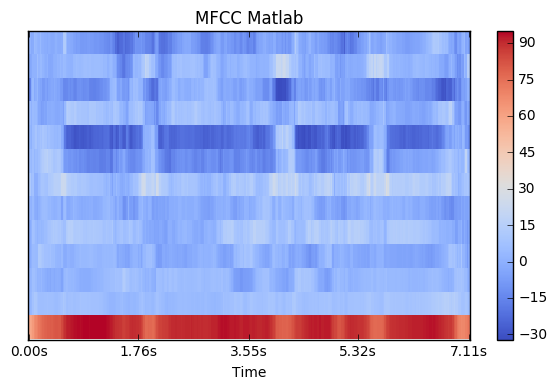

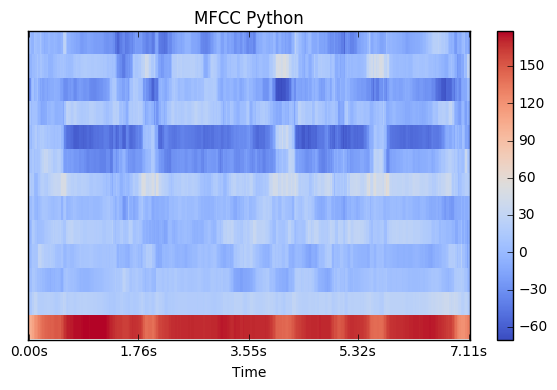

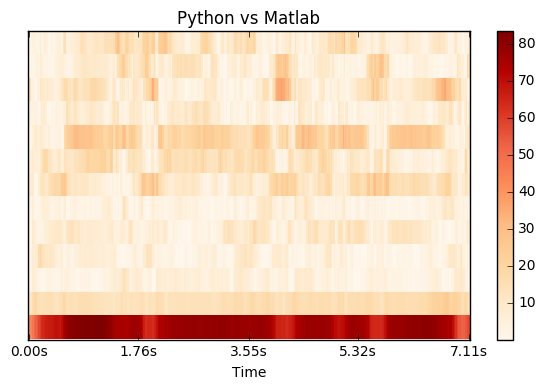

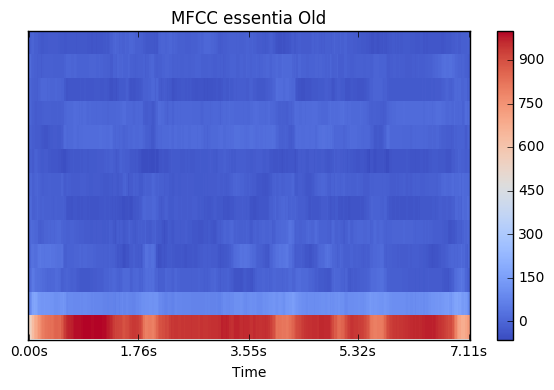

In [8]:
# Processing imitating Matlab
coefficients = 13
bands = 26

# DCT bassis HTK formula, slighly different to librosa implementation
basis1 = np.ones((coefficients, bands))
librosaMFCC = np.zeros([13,307])
liftering = 22

for i in range(0, coefficients):
    for j in range (0, bands):
        basis1[i, j] = np.sqrt(2.0/bands) * np.cos((pi/bands)*(i)* (j+0.5)) 
librosaMFCC =np.dot(basis1, np.log(essentiaMelBands))       

#Liftering
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,i]


#Ploting Matlab
lib.display.specshow(matlabMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Matlab')
plt.tight_layout()
plt.show()

# Librosa
lib.display.specshow(librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Python')
plt.tight_layout()
plt.show()

# Python vs Matlab
lib.display.specshow(np.abs( librosaMFCC - matlabMFCC), x_axis='time')
plt.colorbar()
plt.title('Python vs Matlab')
plt.tight_layout()
plt.show()

#Ploting essentia
lib.display.specshow(essentiaMFCCOld, x_axis='time')
plt.colorbar()
plt.title('MFCC essentia Old')
plt.tight_layout()
plt.show()

In [16]:
print np.mean(essentiaMFCC,1)
print np.mean(htkMFCC,1)

[ 88.74967194   6.35013008  -1.58652735  -5.30904102  -3.74688935
 -13.47427082  -7.39443493 -18.38981438   1.89748061   3.84635115
 -16.34066963  -5.51447248 -14.71643543]
[ 88.78342438   6.36632776  -1.62886882  -5.30124903  -3.92886806
 -13.52705765  -7.62559938 -18.51092339   2.24103594   3.10329103
 -16.25634193  -5.46565485 -14.56163502]
